# Neural Network Deep Learning with Keras Sequential

In [1]:
#dependencies 
import numpy as np
import pandas as pd

In [2]:
#import cleaned data csv
all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
all_wells

,Unnamed: 0,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE
0,15,NO 15/9-F-1 C,289.42,106.35,43.34,107.36,37.94,78.94,631.47,90439.09,0.00,production,OP
1,16,NO 15/9-F-1 C,270.24,107.64,47.17,99.19,60.76,70.63,1166.46,165720.39,0.00,production,OP
2,17,NO 15/9-F-1 C,262.84,107.87,47.73,94.60,63.05,66.05,1549.81,221707.31,0.00,production,OP
3,18,NO 15/9-F-1 C,255.53,107.97,48.53,89.99,64.55,61.41,1248.70,178063.52,0.00,production,OP
4,19,NO 15/9-F-1 C,247.20,108.05,49.84,84.78,65.72,56.15,1345.78,192602.19,0.00,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,8923,NO 15/9-F-15 D,194.98,106.52,31.58,15.81,49.02,1.26,144.01,23201.35,203.93,production,OP
5939,8924,NO 15/9-F-15 D,194.98,106.52,31.54,15.77,48.99,1.20,145.22,23068.07,202.93,production,OP
5940,8925,NO 15/9-F-15 D,194.32,106.52,31.52,15.70,50.10,1.28,142.74,23059.68,203.84,production,OP
5941,8926,NO 15/9-F-15 D,195.21,106.51,31.52,15.61,49.84,1.20,144.46,23090.47,202.76,production,OP


# Neural Network Analysis

### INPUTS: AVG_CHOKE_SIZE_P, AVG_WHP_P, AVG_WHT_P, BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL

In [3]:
#read in data for analysis 
X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
print(X1.shape)

(5943, 6)


In [4]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [6]:
#create the neural network
from tensorflow.keras.models import Sequential
model = Sequential()

In [7]:
#create the model
from tensorflow.keras.layers import Dense
number_inputs = X_train.shape[1]
number_hidden_nodes = 100

model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
model.add(Dense(number_hidden_nodes, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [8]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

Using TensorFlow backend.


In [10]:
#summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
#early stopping tuning #1
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,verbose=0, mode='min')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 1s - loss: 0.6407 - r_square: 0.2793 - rmse: 0.6407 - val_loss: 0.4792 - val_r_square: 0.5205 - val_rmse: 0.4792
Epoch 2/100
1263/1263 - 0s - loss: 0.4061 - r_square: 0.5992 - rmse: 0.4061 - val_loss: 0.3670 - val_r_square: 0.6360 - val_rmse: 0.3670
Epoch 3/100
1263/1263 - 0s - loss: 0.3072 - r_square: 0.7510 - rmse: 0.3072 - val_loss: 0.3023 - val_r_square: 0.6769 - val_rmse: 0.3023
Epoch 4/100
1263/1263 - 0s - loss: 0.2560 - r_square: 0.8037 - rmse: 0.2560 - val_loss: 0.2752 - val_r_square: 0.6829 - val_rmse: 0.2752
Epoch 5/100
1263/1263 - 0s - loss: 0.2290 - r_square: 0.8339 - rmse: 0.2290 - val_loss: 0.2692 - val_r_square: 0.6804 - val_rmse: 0.2692
Epoch 6/100
1263/1263 - 0s - loss: 0.2144 - r_square: 0.8449 - rmse: 0.2144 - val_loss: 0.2507 - val_r_square: 0.6796 - val_rmse: 0.2507
Epoch 7/100
1263/1263 - 0s - loss: 0.2020 - r_square: 0.8461 - rmse: 0.2020 - val_loss: 0.2814 - val_r_square: 0.6452 - val_rmse: 0

In [12]:
#evaluation 1
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 23us/sample - loss: 0.1392 - r_square: 0.8588 - rmse: 0.1392


[0.13924634083604107, 0.8587698, 0.13924634]

In [13]:
#early stopping tuning #2
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_r_square', min_delta=0.000001, patience=5,verbose=0, mode='max')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 0s - loss: 0.1278 - r_square: 0.9103 - rmse: 0.1278 - val_loss: 0.2117 - val_r_square: 0.5930 - val_rmse: 0.2117
Epoch 2/100
1263/1263 - 0s - loss: 0.1323 - r_square: 0.8924 - rmse: 0.1323 - val_loss: 0.2033 - val_r_square: 0.6025 - val_rmse: 0.2033
Epoch 3/100
1263/1263 - 0s - loss: 0.1407 - r_square: 0.8941 - rmse: 0.1407 - val_loss: 0.2066 - val_r_square: 0.6223 - val_rmse: 0.2066
Epoch 4/100
1263/1263 - 0s - loss: 0.1307 - r_square: 0.9037 - rmse: 0.1307 - val_loss: 0.2160 - val_r_square: 0.6026 - val_rmse: 0.2160
Epoch 5/100
1263/1263 - 0s - loss: 0.1304 - r_square: 0.9043 - rmse: 0.1304 - val_loss: 0.2032 - val_r_square: 0.6007 - val_rmse: 0.2032
Epoch 6/100
1263/1263 - 0s - loss: 0.1326 - r_square: 0.9030 - rmse: 0.1326 - val_loss: 0.1926 - val_r_square: 0.6250 - val_rmse: 0.1926
Epoch 7/100
1263/1263 - 0s - loss: 0.1276 - r_square: 0.8989 - rmse: 0.1276 - val_loss: 0.1983 - val_r_square: 0.6194 - val_rmse: 0

In [14]:
#evaluation 2
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 19us/sample - loss: 0.1285 - r_square: 0.8653 - rmse: 0.1285


[0.1285217369268592, 0.86528975, 0.12852173]

# Hyperas Tuning


In [15]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [17]:
#function to scale data for create model function
def data():
    #read in data for analysis 
    all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
    X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
    y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
    #split into test and train data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
    from sklearn.preprocessing import StandardScaler
    # # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # # Transform the training and testing data using the X_scaler and y_scaler models
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train = X_train_scaled.reshape(-1,6)
    x_test = X_test_scaled.reshape(-1,6)
    y_train = y_train_scaled.reshape(-1,1)
    y_test = y_test_scaled.reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [18]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [19]:
#defining the create model function
exec('from __future__ import absolute_import, division, print_function')
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras import backend as K

def create_model(x_train, y_train, x_test, y_test):
    print(x_train.shape)
    model= Sequential() 
    model.add(Dense(100, input_dim=x_train.shape[1], activation= 'relu'))
    model.add(Dropout({{uniform(0,.30)}}))
    model.add(Dense({{choice([50,100,200,300,400])}},activation= 'relu'))
    #model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,.30)}}))
    model.add(Dense(1, activation= 'linear'))

    
################################################
# CREDIT: https://github.com/keras-team/keras/issues/7947
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
    def mse(y_true, y_pred):
        from keras import backend
        return backend.mean(backend.square(y_pred - y_true), axis=-1)
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#############################################

    model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[r_square, rmse])
    from keras.utils import print_summary
    print_summary(model, line_length=None, positions=None, print_fn=None)
    result= model.fit(x_train, y_train,
                      batch_size={{choice([64,128])}},
                      epochs={{choice([50,100,150])}},
                      verbose=2,
                      validation_split =0.15)
    validation_acc= np.min(result.history['val_loss'])
    print('Lowest Validation Loss:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}   

#finding the best model
best_run, best_model= optim.minimize(model=create_model,
                                     data=data,
                                     algo=tpe.suggest,
                                     max_evals=5,
                                     trials=Trials(),
                                     eval_space=True,
                                     notebook_name='NeuralAnalysis')
score= best_model.evaluate(X_test_scaled,y_test_scaled, batch_size= 64)

predictions_test = best_model.predict(X_test_scaled)
predictions_train = best_model.predict(X_train_scaled)

#print best model results
print('Evaluate:', score[0])
#print('Predictions:', predictions[:6])
print('Best Performing Model:', best_run)


>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import losses
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:


Epoch 2/150                                                                                                            
 - 0s - loss: 0.4509 - r_square: 0.5785 - rmse: 0.4509 - val_loss: 0.3311 - val_r_square: 0.7548 - val_rmse: 0.3311    

Epoch 3/150                                                                                                            
 - 0s - loss: 0.3750 - r_square: 0.6757 - rmse: 0.3750 - val_loss: 0.2691 - val_r_square: 0.8004 - val_rmse: 0.2691    

Epoch 4/150                                                                                                            
 - 0s - loss: 0.3420 - r_square: 0.7082 - rmse: 0.3420 - val_loss: 0.2470 - val_r_square: 0.8147 - val_rmse: 0.2470    

Epoch 5/150                                                                                                            
 - 0s - loss: 0.3224 - r_square: 0.7358 - rmse: 0.3224 - val_loss: 0.2397 - val_r_square: 0.8218 - val_rmse: 0.2397    

Epoch 6/150                         

 - 0s - loss: 0.2118 - r_square: 0.8311 - rmse: 0.2118 - val_loss: 0.1740 - val_r_square: 0.8833 - val_rmse: 0.1740    

Epoch 36/150                                                                                                           
 - 0s - loss: 0.2111 - r_square: 0.8330 - rmse: 0.2111 - val_loss: 0.1681 - val_r_square: 0.8873 - val_rmse: 0.1681    

Epoch 37/150                                                                                                           
 - 0s - loss: 0.2111 - r_square: 0.8336 - rmse: 0.2111 - val_loss: 0.1626 - val_r_square: 0.8843 - val_rmse: 0.1626    

Epoch 38/150                                                                                                           
 - 0s - loss: 0.2072 - r_square: 0.8317 - rmse: 0.2072 - val_loss: 0.1656 - val_r_square: 0.8870 - val_rmse: 0.1656    

Epoch 39/150                                                                                                           
 - 0s - loss: 0.2061 - r_square: 0.8

Epoch 69/150                                                                                                           
 - 0s - loss: 0.1890 - r_square: 0.8534 - rmse: 0.1890 - val_loss: 0.1527 - val_r_square: 0.8966 - val_rmse: 0.1527    

Epoch 70/150                                                                                                           
 - 0s - loss: 0.1913 - r_square: 0.8468 - rmse: 0.1913 - val_loss: 0.1502 - val_r_square: 0.8941 - val_rmse: 0.1502    

Epoch 71/150                                                                                                           
 - 0s - loss: 0.1876 - r_square: 0.8600 - rmse: 0.1876 - val_loss: 0.1510 - val_r_square: 0.8976 - val_rmse: 0.1510    

Epoch 72/150                                                                                                           
 - 0s - loss: 0.1898 - r_square: 0.8443 - rmse: 0.1898 - val_loss: 0.1486 - val_r_square: 0.8962 - val_rmse: 0.1486    

Epoch 73/150                        

 - 0s - loss: 0.1816 - r_square: 0.8632 - rmse: 0.1816 - val_loss: 0.1527 - val_r_square: 0.8996 - val_rmse: 0.1527    

Epoch 103/150                                                                                                          
 - 0s - loss: 0.1839 - r_square: 0.8601 - rmse: 0.1839 - val_loss: 0.1442 - val_r_square: 0.8993 - val_rmse: 0.1442    

Epoch 104/150                                                                                                          
 - 0s - loss: 0.1809 - r_square: 0.8602 - rmse: 0.1809 - val_loss: 0.1531 - val_r_square: 0.8975 - val_rmse: 0.1531    

Epoch 105/150                                                                                                          
 - 0s - loss: 0.1801 - r_square: 0.8671 - rmse: 0.1801 - val_loss: 0.1479 - val_r_square: 0.9018 - val_rmse: 0.1479    

Epoch 106/150                                                                                                          
 - 0s - loss: 0.1815 - r_square: 0.8

Epoch 136/150                                                                                                          
 - 0s - loss: 0.1711 - r_square: 0.8663 - rmse: 0.1711 - val_loss: 0.1467 - val_r_square: 0.9071 - val_rmse: 0.1467    

Epoch 137/150                                                                                                          
 - 0s - loss: 0.1759 - r_square: 0.8653 - rmse: 0.1759 - val_loss: 0.1563 - val_r_square: 0.9000 - val_rmse: 0.1563    

Epoch 138/150                                                                                                          
 - 0s - loss: 0.1715 - r_square: 0.8769 - rmse: 0.1715 - val_loss: 0.1511 - val_r_square: 0.9046 - val_rmse: 0.1511    

Epoch 139/150                                                                                                          
 - 0s - loss: 0.1726 - r_square: 0.8662 - rmse: 0.1726 - val_loss: 0.1360 - val_r_square: 0.9066 - val_rmse: 0.1360    

Epoch 140/150                       

Epoch 9/50                                                                                                             
 - 0s - loss: 0.2574 - r_square: 0.7964 - rmse: 0.2574 - val_loss: 0.2036 - val_r_square: 0.8497 - val_rmse: 0.2036    

Epoch 10/50                                                                                                            
 - 0s - loss: 0.2558 - r_square: 0.8087 - rmse: 0.2558 - val_loss: 0.2010 - val_r_square: 0.8523 - val_rmse: 0.2010    

Epoch 11/50                                                                                                            
 - 0s - loss: 0.2447 - r_square: 0.8136 - rmse: 0.2447 - val_loss: 0.2036 - val_r_square: 0.8551 - val_rmse: 0.2036    

Epoch 12/50                                                                                                            
 - 0s - loss: 0.2465 - r_square: 0.8102 - rmse: 0.2465 - val_loss: 0.2024 - val_r_square: 0.8531 - val_rmse: 0.2024    

Epoch 13/50                         

 - 0s - loss: 0.1910 - r_square: 0.8592 - rmse: 0.1910 - val_loss: 0.1901 - val_r_square: 0.8855 - val_rmse: 0.1901    

Epoch 43/50                                                                                                            
 - 0s - loss: 0.1934 - r_square: 0.8579 - rmse: 0.1934 - val_loss: 0.1816 - val_r_square: 0.8893 - val_rmse: 0.1816    

Epoch 44/50                                                                                                            
 - 0s - loss: 0.1873 - r_square: 0.8665 - rmse: 0.1873 - val_loss: 0.1736 - val_r_square: 0.8916 - val_rmse: 0.1736    

Epoch 45/50                                                                                                            
 - 0s - loss: 0.1946 - r_square: 0.8612 - rmse: 0.1946 - val_loss: 0.1860 - val_r_square: 0.8874 - val_rmse: 0.1860    

Epoch 46/50                                                                                                            
 - 0s - loss: 0.1892 - r_square: 0.8

 - 0s - loss: 0.2198 - r_square: 0.8353 - rmse: 0.2198 - val_loss: 0.1939 - val_r_square: 0.8696 - val_rmse: 0.1939    

Epoch 16/100                                                                                                           
 - 0s - loss: 0.2185 - r_square: 0.8168 - rmse: 0.2185 - val_loss: 0.1976 - val_r_square: 0.8668 - val_rmse: 0.1976    

Epoch 17/100                                                                                                           
 - 0s - loss: 0.2154 - r_square: 0.8390 - rmse: 0.2154 - val_loss: 0.1840 - val_r_square: 0.8751 - val_rmse: 0.1840    

Epoch 18/100                                                                                                           
 - 0s - loss: 0.2142 - r_square: 0.8385 - rmse: 0.2142 - val_loss: 0.1918 - val_r_square: 0.8792 - val_rmse: 0.1918    

Epoch 19/100                                                                                                           
 - 0s - loss: 0.2073 - r_square: 0.8

Epoch 49/100                                                                                                           
 - 0s - loss: 0.1705 - r_square: 0.8695 - rmse: 0.1705 - val_loss: 0.1817 - val_r_square: 0.8923 - val_rmse: 0.1817    

Epoch 50/100                                                                                                           
 - 0s - loss: 0.1707 - r_square: 0.8753 - rmse: 0.1707 - val_loss: 0.1819 - val_r_square: 0.8926 - val_rmse: 0.1819    

Epoch 51/100                                                                                                           
 - 0s - loss: 0.1719 - r_square: 0.8713 - rmse: 0.1719 - val_loss: 0.1706 - val_r_square: 0.8944 - val_rmse: 0.1706    

Epoch 52/100                                                                                                           
 - 0s - loss: 0.1730 - r_square: 0.8766 - rmse: 0.1730 - val_loss: 0.1693 - val_r_square: 0.8975 - val_rmse: 0.1693    

Epoch 53/100                        

 - 0s - loss: 0.1615 - r_square: 0.8788 - rmse: 0.1615 - val_loss: 0.1822 - val_r_square: 0.8943 - val_rmse: 0.1822    

Epoch 83/100                                                                                                           
 - 0s - loss: 0.1541 - r_square: 0.8862 - rmse: 0.1541 - val_loss: 0.1697 - val_r_square: 0.8978 - val_rmse: 0.1697    

Epoch 84/100                                                                                                           
 - 0s - loss: 0.1525 - r_square: 0.8900 - rmse: 0.1525 - val_loss: 0.1709 - val_r_square: 0.8995 - val_rmse: 0.1709    

Epoch 85/100                                                                                                           
 - 0s - loss: 0.1538 - r_square: 0.8866 - rmse: 0.1538 - val_loss: 0.1812 - val_r_square: 0.8914 - val_rmse: 0.1812    

Epoch 86/100                                                                                                           
 - 0s - loss: 0.1569 - r_square: 0.8

 - 0s - loss: 0.2871 - r_square: 0.7668 - rmse: 0.2871 - val_loss: 0.2167 - val_r_square: 0.8421 - val_rmse: 0.2167    

Epoch 6/100                                                                                                            
 - 0s - loss: 0.2740 - r_square: 0.7705 - rmse: 0.2740 - val_loss: 0.2097 - val_r_square: 0.8513 - val_rmse: 0.2097    

Epoch 7/100                                                                                                            
 - 0s - loss: 0.2579 - r_square: 0.7932 - rmse: 0.2579 - val_loss: 0.2204 - val_r_square: 0.8504 - val_rmse: 0.2204    

Epoch 8/100                                                                                                            
 - 0s - loss: 0.2549 - r_square: 0.7880 - rmse: 0.2549 - val_loss: 0.1970 - val_r_square: 0.8626 - val_rmse: 0.1970    

Epoch 9/100                                                                                                            
 - 0s - loss: 0.2462 - r_square: 0.8

Epoch 39/100                                                                                                           
 - 0s - loss: 0.1836 - r_square: 0.8470 - rmse: 0.1836 - val_loss: 0.1861 - val_r_square: 0.8879 - val_rmse: 0.1861    

Epoch 40/100                                                                                                           
 - 0s - loss: 0.1779 - r_square: 0.8558 - rmse: 0.1779 - val_loss: 0.1803 - val_r_square: 0.8881 - val_rmse: 0.1803    

Epoch 41/100                                                                                                           
 - 0s - loss: 0.1809 - r_square: 0.8531 - rmse: 0.1809 - val_loss: 0.1908 - val_r_square: 0.8888 - val_rmse: 0.1908    

Epoch 42/100                                                                                                           
 - 0s - loss: 0.1821 - r_square: 0.8556 - rmse: 0.1821 - val_loss: 0.1702 - val_r_square: 0.8934 - val_rmse: 0.1702    

Epoch 43/100                        

 - 0s - loss: 0.1632 - r_square: 0.8704 - rmse: 0.1632 - val_loss: 0.1875 - val_r_square: 0.8909 - val_rmse: 0.1875    

Epoch 73/100                                                                                                           
 - 0s - loss: 0.1629 - r_square: 0.8662 - rmse: 0.1629 - val_loss: 0.1836 - val_r_square: 0.8921 - val_rmse: 0.1836    

Epoch 74/100                                                                                                           
 - 0s - loss: 0.1612 - r_square: 0.8674 - rmse: 0.1612 - val_loss: 0.1913 - val_r_square: 0.8887 - val_rmse: 0.1913    

Epoch 75/100                                                                                                           
 - 0s - loss: 0.1580 - r_square: 0.8701 - rmse: 0.1580 - val_loss: 0.1758 - val_r_square: 0.8988 - val_rmse: 0.1758    

Epoch 76/100                                                                                                           
 - 0s - loss: 0.1649 - r_square: 0.8

dense_14 (Dense)             (None, 200)               20200                                                           
_________________________________________________________________                                                      
dropout_10 (Dropout)         (None, 200)               0                                                               
_________________________________________________________________                                                      
dense_15 (Dense)             (None, 1)                 201                                                             
Total params: 21,101                                                                                                   
Trainable params: 21,101                                                                                               
Non-trainable params: 0                                                                                                
________________________________________

 - 0s - loss: 0.1583 - r_square: 0.8579 - rmse: 0.1583 - val_loss: 0.1500 - val_r_square: 0.8992 - val_rmse: 0.1500    

Epoch 30/50                                                                                                            
 - 0s - loss: 0.1594 - r_square: 0.8629 - rmse: 0.1594 - val_loss: 0.1367 - val_r_square: 0.8976 - val_rmse: 0.1367    

Epoch 31/50                                                                                                            
 - 0s - loss: 0.1591 - r_square: 0.8567 - rmse: 0.1591 - val_loss: 0.1407 - val_r_square: 0.9003 - val_rmse: 0.1407    

Epoch 32/50                                                                                                            
 - 0s - loss: 0.1594 - r_square: 0.8618 - rmse: 0.1594 - val_loss: 0.1381 - val_r_square: 0.9008 - val_rmse: 0.1381    

Epoch 33/50                                                                                                            
 - 0s - loss: 0.1551 - r_square: 0.8

In [20]:
#result metrics
best_model.metrics_names

['loss', 'r_square', 'rmse']

In [21]:
#using data to evaluate best model 
x_train, y_train, x_test, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test, verbose=3))

Evalutation of best performing model:
[0.17111314849208534, 0.8860461711883545, 0.17111314833164215]


In [22]:
#using model to predict y values
predictions = best_model.predict(X_test_scaled)
predictions1 = best_model.predict(X_train_scaled)

#predictions= test
#predictions1= train 


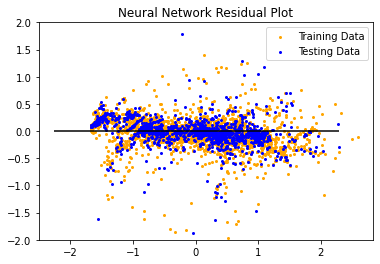

In [23]:
# Plot Residuals
import matplotlib.pyplot as plt

plt.title('Neural Network Residual Plot')
plt.scatter(predictions1, predictions1 - y_train_scaled, c= "orange",label="Training Data", s=4)
plt.scatter(predictions, predictions - y_test_scaled, c= "blue",label="Testing Data",s=4)
plt.ylim(-2,2)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.legend()

plt.savefig('neuralnetworkresidual.png')
plt.show()

In [24]:
# Score the prediction with mse and r2 (train data)
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train_scaled, predictions1)
r2_train = r2_score(y_train_scaled, predictions1)

In [25]:
# Score the prediction with mse and r2 (test data)
mse_test = mean_squared_error(y_test_scaled, predictions)
r2_test = r2_score(y_test_scaled, predictions)

In [26]:
print(f"Mean Squared Error (MSE) Train Data: {mse_train}")
print(f"R-squared (R2) Train Data: {r2_train}")
print("-----------------------------------")
print(f"Mean Squared Error (MSE) Test Data: {mse_test}")
print(f"R-squared (R2) Test Data: {r2_test}")

Mean Squared Error (MSE) Train Data: 0.13920958578125808
R-squared (R2) Train Data: 0.8607904142187419
-----------------------------------
Mean Squared Error (MSE) Test Data: 0.1399211308376265
R-squared (R2) Test Data: 0.8577363184421886
